In [18]:
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import re
import gensim
from gensim.models import Word2Vec

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# dataset location
DATASET = "data/prospect-data.csv"

# load dataset into dataframe
data = pd.read_csv(DATASET)

data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2022,LW,76.0,218.0,1,MON,1.0,Juraj Slafkovsky,Slafkovsky has all the assets you're looking f...,Slafkovsky is one of the draft's most tantaliz...,Slafkovsky can be a menace at the NHL level. H...,The potential of what Slafkovsky can be as he ...,Slafkovsky is one of the largest players in th...,Nothing brought out Juraj Slafkovsky's draft y...,Slafkovsky dominated the international scene t...,Juraj Slafkovsky drives offense from the wing....
1,2022,C,72.5,193.0,4,SEA,2.0,Shane Wright,Wright is a very well-rounded center who has n...,Still my top prospect in this class (though no...,The complicated and essential question to answ...,With high-end hockey sense highlighted by his ...,The top player from the class held this positi...,In a draft year shaped by substantial depth ra...,Wright has been on the radar of scouts for a l...,Shane Wright is an elite two-way center with i...
2,2022,D,72.0,190.0,2,NJD,4.0,Simon Nemec,Nemec is a very well-rounded defenseman. His p...,This kid turned 18 in the middle of February a...,"With Nemec, you are netting a top pairing defe...","One of the very best passers in this draft, Ne...",The statistical comparables to Nemec's draft y...,Šimon Nemec just put together the most product...,Few players have been as dominant at the pro-l...,Simon Nemec is a mobile two-way and highly-int...
3,2022,C,70.5,180.0,3,ARI,3.0,Logan Cooley,Cooley is a dynamic player. When he has the pu...,"Cooley is a beautiful, flowing skater capable ...",Logan Cooley is for sure one of the more well-...,"Over the last several months, I have constantl...","A highly creative, speed-driven pivot who brin...",You won't find a more singularly-gifted puckha...,"A small, speedy center, Cooley dominated the U...",Juraj Slafkovsky drives offense from the wing....
4,2022,D,75.0,189.0,6,CBJ,5.0,David Jiricek,"Jiricek is a big, right-shot defenseman who ma...",After suffering a knee injury at the world jun...,Top pairing defenseman at the NHL level if he ...,"A highly mobile, 6-foot-3 defenseman with a bo...","A knee injury fractured Jiříček's season, but ...",David Jiříček finishes the year as the highest...,"Similar to Nemec, Jiricek plays a mature game ...",David Jiricek is an exceptional two-way defens...


In [20]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               360 non-null    int64  
 1   Position                           360 non-null    object 
 2   Height                             360 non-null    float64
 3   Weight                             360 non-null    float64
 4   Drafted                            360 non-null    int64  
 5   Team                               360 non-null    object 
 6   Average Ranking                    120 non-null    float64
 7   Name                               360 non-null    object 
 8   Description - Corey Pronman        347 non-null    object 
 9   Description - Scott Wheeler        171 non-null    object 
 10  Description - Smaht Scouting       107 non-null    object 
 11  Description - ESPN (Chris Peters)  187 non-null    object 

In [21]:
# clean up dataset
# might have to look at dropping seattle in the future but for clustering it 
# should not matter
#data = data[data['Team'] != 'SEA']

# try with only forwards
#data = data[(data['Position'] == 'C') | (data['Position'] == 'LW') | (data['Position'] == 'RW')]

# encode position
# TODO: we should keep the positions for when we do clustering
le = preprocessing.LabelEncoder()
le.fit(data['Position'].unique())
data['Position'] = data['Position'].apply(lambda x: le.transform([x])[0])


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               360 non-null    int64  
 1   Position                           360 non-null    int32  
 2   Height                             360 non-null    float64
 3   Weight                             360 non-null    float64
 4   Drafted                            360 non-null    int64  
 5   Team                               360 non-null    object 
 6   Average Ranking                    120 non-null    float64
 7   Name                               360 non-null    object 
 8   Description - Corey Pronman        347 non-null    object 
 9   Description - Scott Wheeler        171 non-null    object 
 10  Description - Smaht Scouting       107 non-null    object 
 11  Description - ESPN (Chris Peters)  187 non-null    object 

In [23]:
corpus, labels, draft_position, player_position, player_name, height, weight = [], [], [], [], [], [], []

scouting_reports = [
    'Description - Corey Pronman',
    'Description - Scott Wheeler',
    'Description - Smaht Scouting',
    'Description - ESPN (Chris Peters)',
    'Description - EP Rinkside', 
    'Description - EP Rinkside Part 2',
    'Description - The Painted Lines',
    'Description - FCHockey'
]

# create a list of stopwords for player names
player_names = list(data['Name'])
name_stopwords = []
for name in player_names:
  name_split = name.split(' ')
  for part in name_split:
    name_stopwords.append(part.lower())

# remove references to leagues, teams, and nationalities
hockey_words = []
"""
hockey_words = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "saginaw", "kelowna"]
"""

# Initialize Python porter stemmer
ps = PorterStemmer()

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

for index, row in data.iterrows():
  text = ""
  for report in scouting_reports:
    # skip null reports
    if pd.isnull(row[report]):
      continue

    # keep only alpha characters
    r = re.sub('[^a-zA-Z]', ' ', row[report])
    # lower string everything
    r = r.lower()
    # split on spaces
    r = r.split()
    # remove stopwords and any reference to the name of the player
    # TODO: check whether we should initialize stopwords, so we don't call this fuction every time
    r = [word for word in r if word not in stopwords.words('english') and word not in name_stopwords and word not in hockey_words]

    # stem cleansed string
    r = [ps.stem(word) for word in r]
    # lemmatize cleansed string
    #r = [lemmatizer.lemmatize(word) for word in r]

    # remove hockey specific stop words
    #r = [word for word in r if word not in hockey_words]

    # join back on spaces
    r = ' '.join(r)
    text = text + " " + r
  # append to dataset
  corpus.append(text)
  labels.append(row['Team'])
  draft_position.append(row['Drafted'])
  player_position.append(row['Position'])
  player_name.append(row['Name'])
  height.append(row['Height'])
  weight.append(row['Weight'])

# sanity check values
print(f"length of corpus: {len(corpus)}")
print(f"length of labels: {len(labels)}")
print(f"length of draft_position: {len(draft_position)}")
print(f"length of player_position: {len(player_position)}")

print(f"corpus first 5: {corpus[0:5]}")
print(f"labels first 5: {labels[0:5]}")
print(f"draft_position first 5: {draft_position[0:5]}")
print(f"player_position first 5: {player_position[0:5]}")

length of corpus: 360
length of labels: 360
length of draft_position: 360
length of player_position: 360
corpus first 5: [' asset look top nhl forward foot winger beat oppon speed skill possess outstand puck skill put puck leg stick high rate use finess quick get around defend also set finish play well physic run guy compet good enough project top line winger potenti pop becom true star nhl one draft tantal prospect skill size combo scout coach clamour alreadi demonstr pro competit domest notabl intern big year nine point five game histor silver medal slovak hlinka gretzki cup olymp bronz medal tournament mvp liiga silver medal club team tp team lead nine point men world built like forward pound frame make one draft heaviest player play game uncharacterist finess regularli flash hand expect smaller player one one pull puck tight feet also got rangi fluid stride make surprisingli danger rush player impress confid puck stick enabl hang onto sometim fault attack wall slot love take puck h

In [24]:
X = pd.DataFrame(list(zip(player_name, height, weight, draft_position, player_position, corpus)), columns=['player_name', 'height', 'weight', 'draft_position', 'player_position', 'report'])
Y = labels

# create train test splits of data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

# vectorize train data
vectorizer = TfidfVectorizer(analyzer='word', min_df=0.04, ngram_range=(1, 3))
X_train_vect = vectorizer.fit_transform(X_train['report'])
print(f"shape of X_train_vect: {X_train_vect.shape}")

# show the most important words
most_important = pd.DataFrame(X_train_vect[0].T.todense(),
    	index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
most_important = most_important.sort_values('TF-IDF', ascending=False)
most_important.head(30)

shape of X_train_vect: (241, 2296)


,TF-IDF
puck,0.173826
one,0.150535
like,0.127029
draft,0.126255
hold,0.120081
game,0.117224
crossov,0.114135
swedish,0.109027
releas,0.105677
speed,0.104653


In [13]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(6, 6)

In [ ]:
# this is flawed and from some previous work I was doing but I wanted to keep
# around since it is a good example of setting up a pipeline in sklearn
# so it could be used for a reference
"""
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create Function Transformer to use Feature Union
def get_numeric_data(x):
    return [[row['player_position']] for index, row in x[['draft_position', 'player_position']].iterrows()]

def get_text_data(x):
    return list(x['report'])

transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

# Create a pipeline to concatenate Tfidf Vector and Numeric data
# Use RandomForestClassifier as an example
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word', ngram_range=(1,2)))
            ]))
         ])),
    ('clf', LogisticRegression())
])


# Grid Search Parameters for LogisticRegression
param_grid = {'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 20),
              'clf__solver' : ['liblinear']
              }

# Training config
kfold = StratifiedKFold(n_splits=3)
scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

# Perform GridSearch
rf_model = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=scoring, 
                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_

# best found for now to be 0.16 
# without draft position (I think there is bias with that data)
rf_best.score(X_test, y_test)
"""

"\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.pipeline import Pipeline, FeatureUnion\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.preprocessing import FunctionTransformer\nfrom sklearn.model_selection import GridSearchCV, StratifiedKFold\n\n# Create Function Transformer to use Feature Union\ndef get_numeric_data(x):\n    return [[row['player_position']] for index, row in x[['draft_position', 'player_position']].iterrows()]\n\ndef get_text_data(x):\n    return list(x['report'])\n\ntransfomer_numeric = FunctionTransformer(get_numeric_data)\ntransformer_text = FunctionTransformer(get_text_data)\n\n# Create a pipeline to concatenate Tfidf Vector and Numeric data\n# Use RandomForestClassifier as an example\npipeline = Pipeline([\n    ('features', FeatureUnion([\n            ('numeric_features', Pipeline([\n                ('selector', transfomer_numeric)\n            ])),\n             ('text_features', Pipeline([\n                ('selec

Exploring Kmeans now for unsupervised learning

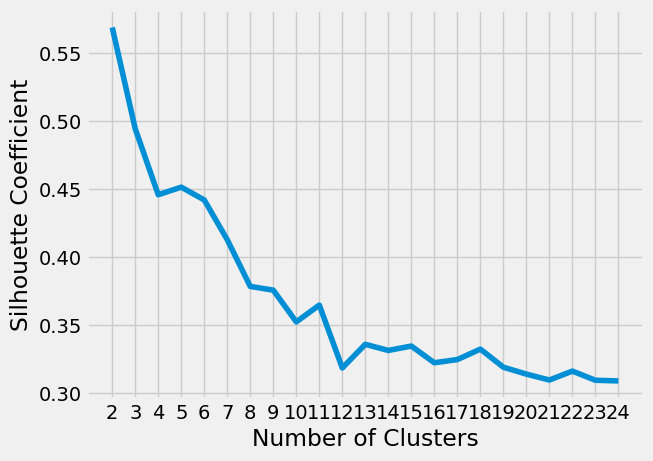

In [36]:
def plot_silhouette_scores(data, start, end, step):
  # A list holds the silhouette coefficients for each k
  silhouette_coefficients = []
  formated_data = data

  # Notice you start at 2 clusters for silhouette coefficient
  for k in range(start, end, step):
    kmeans = KMeans(n_clusters=k, n_init=2, max_iter=1000)
    kmeans.fit(formated_data)
    score = silhouette_score(formated_data, kmeans.labels_)
    silhouette_coefficients.append(score)

  plt.style.use("fivethirtyeight")
  plt.plot(range(start, end, step), silhouette_coefficients)
  plt.xticks(range(start, end, step))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()


formated_data = np.vstack(X_train_vect)
temp_data = []
for index, row in enumerate(X_train_vect):
  temp_data.append(np.concatenate((X_train_vect[index].toarray()[0], [X_train['height'].values[index]], [X_train['weight'].values[index]])))
  #formated_data[index] = np.append(formated_data[index], X_train['weight'].values[index])
data = np.array(temp_data)
plot_silhouette_scores(data, 2, 25, 1)

The extremely low silhouette score implies there is a lot of overlap in classification of values. There might have to be some more data massaging in order to get this value higher

In [31]:
SELECTED_CLUSTERS = 3

In [32]:
# use the number of clusters found to be the best in graph above
kmeans = KMeans(n_clusters=SELECTED_CLUSTERS, n_init = 5)
labels = kmeans.fit_predict(X_train_vect)

X_train['label'] = labels

In [33]:
# show the top words for each cluster that was created
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X_train_vect, X_train.label, vectorizer.get_feature_names_out(), 15)


Cluster 0.0
ice,one,top,nhl,zone,well,good,skill,get,offens,player,game,make,puck,play

Cluster 1.0
top,defens,skill,well,one,good,zone,get,season,offens,player,make,game,play,puck

Cluster 2.0
use,pass,ice,get,zone,defens,one,good,game,offens,player,well,make,play,puck


In [34]:
import plotly.express as px

print(X_train.columns)
print(X_train.head())

#visualize mappings via treemap
result_summary = pd.pivot_table(X_train, index=['label', 'player_name'],  aggfunc='count').reset_index().rename(columns={'draft_position':'count'})
result_treemap = result_summary
fig = px.treemap(result_treemap,path=['label', 'player_name'],values='count')
fig.show()

Index(['player_name', 'height', 'weight', 'draft_position', 'player_position',
       'report', 'label'],
      dtype='object')
             player_name  height  weight  draft_position  player_position  \
97           Noel Gunler   74.00   176.0              41                4   
122           Kirby Dach   76.00   198.0               3                0   
287        Zach Werenski   74.00   206.0               8                1   
307  Anthony Beauvillier   70.25   173.0              28                3   
288           Timo Meier   73.00   209.0               9                4   

                                                report  label  
97    play season shl get limit minut one top team ...      1  
122   think team look center look lot like right sh...      1  
287   incred season arguabl michigan best defensema...      2  
307   former top pick qmjhl draft shawnigan good se...      0  
288   pretti success second season north america ra...      0  


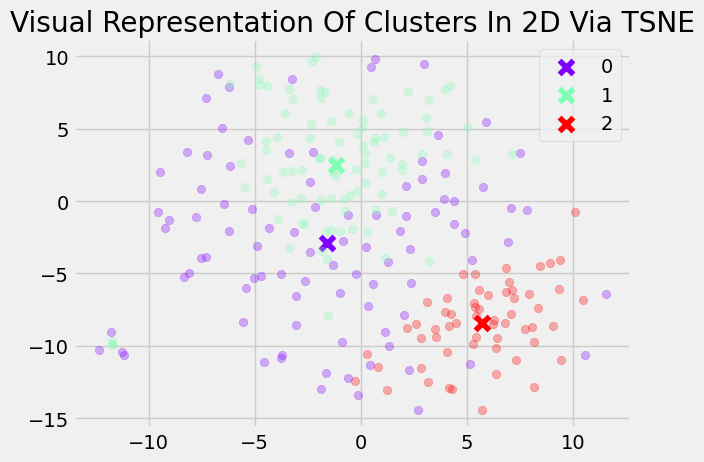

In [35]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(X_train_vect)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

color = cm.rainbow(np.linspace(0, 1, len(X_train.label.unique())))
for category, color in enumerate(color):
    xs = np.array(x)[X_train.label == category]
    ys = np.array(y)[X_train.label == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=category)
plt.title("Visual Representation Of Clusters In 2D Via TSNE")
plt.legend()